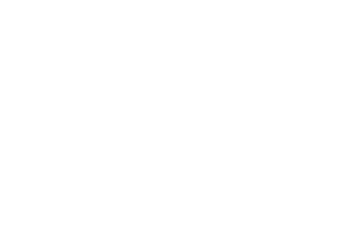

In [56]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score

# globals
batch_size = 32
plt.axis('off')

# set random state
rs = 42
np.random.seed(42)

In [57]:
x_dim = 464 # 474
y_dim = 12 # 12

In [58]:
# load every image with imgwrite
path = "chromagrams3/"

am = 5287
image_names = os.listdir(path)[:am]

temp, test_files = train_test_split(image_names, train_size=0.85, random_state=rs, shuffle=True)
train_files, val_files = train_test_split(temp, train_size=0.8, random_state=rs, shuffle=True)

In [59]:
# Make this an infinite generator
def gen(img_names):

  while True:

    i = 0
    images = np.zeros((batch_size,y_dim,x_dim), dtype=np.float64)

    while i < len(img_names):
      complete_path = path + img_names[i]
      images[i%batch_size,:,:] = cv2.imread(complete_path, cv2.IMREAD_GRAYSCALE)[:y_dim,:x_dim]/255
      i += 1
      if i%batch_size == 0:
        images = images.reshape(batch_size, y_dim, x_dim, 1)
        yield (images, images)
        images = np.zeros((batch_size,y_dim,x_dim))

In [60]:
train = gen(train_files)
val   = gen(val_files)
test  = gen(test_files)

In [61]:
def imshow(img):
    img = np.fliplr(img.reshape(-1,3)).reshape(img.shape)
    plt.figure(figsize=(30, 10))
    plt.imshow(img, cmap='gray')
    print(img.shape)
    plt.xticks([]), plt.yticks([]) # optional line of code, just to hide tick values on X and Y axis if needed
    plt.show()

(12, 464, 1)


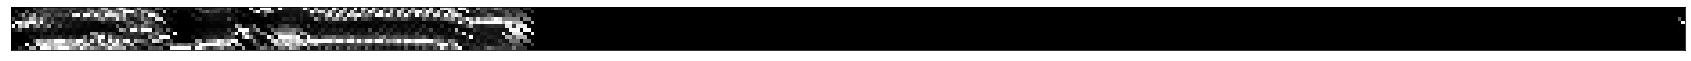

In [62]:
test_batch = next(test)[0]

img = test_batch[rs%batch_size]
imshow(img)



In [63]:
# am_test_steps = len(test_files)//batch_size
# encodings = np.zeros((am_test_steps*batch_size, x_dim*y_dim)) # note the integer rounding here

# for i in range(am_test_steps):
# 	batch = next(test)[0]
# 	batch = batch.reshape((batch_size,x_dim*y_dim))
# 	for j in range(batch_size):
# 		encodings[i*batch_size,:] = batch[j,:]

In [64]:
am_test_steps = len(test_files)//batch_size
encoded_imgs = []

for i in range(am_test_steps):
    # take only x pair of data, then reshape the last dimension (the (x,y,1) that the neural model requires) out so that pca accepts
    batch = np.array(next(test)[0].reshape((batch_size, y_dim, x_dim)))
    for j in range(batch_size):
        chromagram = batch[j,:,:]
        res = PCA().fit_transform(chromagram)
        res = res.reshape(res.shape[0]*res.shape[1])
        encoded_imgs.append(res)

In [65]:
cluster_number = range(2,120) 

distortions = []
silhouette_scores = []
calinski_harabasz_scores = []
for n in cluster_number:
    print(n, end=' ')
    estimator = KMeans(n_clusters = n, init='k-means++', n_init=10, max_iter=300)
    y = estimator.fit_predict(encoded_imgs)
    distortions.append(estimator.inertia_)
    silhouette_scores.append(silhouette_score(encoded_imgs,y))
    calinski_harabasz_scores.append(calinski_harabasz_score(encoded_imgs,y))
print()

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 


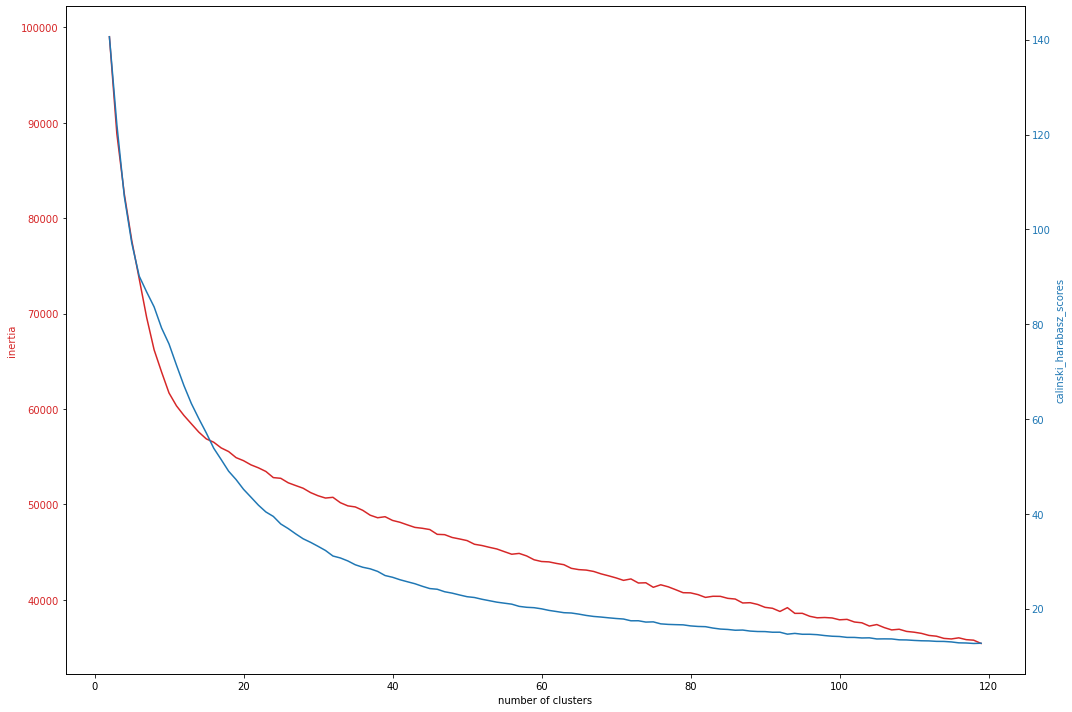

In [67]:
t = cluster_number
data1 = distortions
data2 = calinski_harabasz_scores#silhouette_scores

fig, ax1 = plt.subplots(figsize = (15, 10))
          
color = 'tab:red'
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('inertia', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('calinski_harabasz_scores', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()